In [2]:
Name          = 'Madeira'                 # Project Name

# Data Limits parameters
pos_start     = 50                      # Fiber position start in [m]
pos_stop      = 10000                   # Fiber position stop  in [m]
time_start    = 0.2                     # Aquisition time start in [min]
time_stop     = 10                      # Aquisition time stop  in [min]

In [3]:
import numpy as np
import os
from models.HDAS_file_convert import HDAS_2DMap, HDAS_meas_settings, sampling_file_name

data_folder      = os.path.join(os.path.dirname(os.getcwd()), 'Data', 'MODAS', Name)
day_folder_list  = sampling_file_name(data_folder)
arg_file         = day_folder_list[0] + os.sep + os.listdir(day_folder_list[0])[0]

data_args        = HDAS_meas_settings( arg_file )
for key, value in data_args.items():
    print(f"> {key:<{17}}: {value}")

print("\n>> Load 2D HDAS Map")
data_memmap, data_args = HDAS_2DMap(day_folder_list[0], (pos_start, pos_stop), (time_start*60, time_stop*60))

Data = np.array(data_memmap)
del data_memmap

FileNotFoundError: [WinError 3] O sistema não conseguiu localizar o caminho especificado: 'c:\\Users\\gteix\\Projectos\\QuLab\\MODAS\\Data\\MODAS\\Madeira'

In [1]:
from models.HDAS_signal_time     import DeMean_data, Normalize_MinMax
from models.HDAS_signal_spectrum import BandPass_filter
from scipy import signal
import matplotlib.pyplot as plt

# User filter parameters
fs         = 50
f_low      = 0.02
f_high     = 0.99*0.5*fs

## Data Cleaning
print("> Detrend Data ...")
demeaned   = DeMean_data(Data)
detrend    = signal.detrend(demeaned, axis=1)

print(f"> Band-Pass Filter: fc = [ {f_low} , {f_high} ] Hz ...")
filtered   = BandPass_filter(detrend, f_low, f_high, fs)

print("> Normalize Data ...")
norm_data  = Normalize_MinMax(filtered, axis=1)

## Plot´
print("> Plot Data ...")
plot_data   = [Data]
Title       = ['Raw Data']
plot_data  += [demeaned]
Title      += ['De-Meaned Data']
plot_data  += [detrend]
Title      += ['De-Trended Data']
plot_data  += [filtered]
Title      += ['Filtered Data']
plot_data  += [norm_data]
Title      += ['Normalized Data']

x_vals  = np.linspace( time_start, time_stop, Data.shape[1] )
y_vals  = np.linspace( pos_start, pos_stop, Data.shape[0] )
cmap    = 'bone'
n_plots = len(plot_data)

plt.figure(figsize=(16, 8))

for i in range(n_plots):
    
    plt.subplot(2, 3, i+1)
    plt.title(Title[i])
    plt.imshow(plot_data[i], cmap=cmap, extent=[x_vals[0], x_vals[-1], y_vals[-1], y_vals[0]], aspect='auto')
    plt.colorbar()

    # Set custom x and y ticks
    plt.xticks(np.linspace(x_vals[0], x_vals[-1], 8))
    plt.yticks(np.linspace(y_vals[0], y_vals[-1], 8))

    plt.ylabel("Fiber Lenght [m]")
    plt.xlabel("Time [min]")

    # Move the x-axis to the top
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')

plt.tight_layout()
plt.show()

> Detrend Data ...


NameError: name 'Data' is not defined

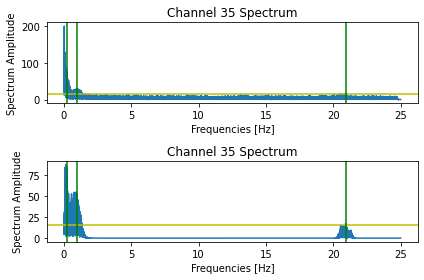

In [4]:
from models.HDAS_signal_spectrum import spectrum, select_peaks

# User filter parameters
fs         = 50
delta_f    = 1
n_peaks    = 150
chan       = 35

# Detrend data Spectrum
data_arr            = norm_data[chan]
spect_arr, freq_arr = spectrum(data_arr)
data                = np.vstack((spect_arr, freq_arr))
limit               = int( len(spect_arr)*1/5 )

# Spectral analysis
peaks        = select_peaks(spect_arr, n_peaks, 0, fs/2)[1:]
noise_level  = np.mean(spect_arr[limit:]) + np.mean(spect_arr[peaks])
peaks        = np.array([p for p in peaks if spect_arr[p] >= noise_level])

# Filter peaks by neighbour
index_bin_size = len(spect_arr) // n_peaks
cc             = 1
counts         = np.ones(len(peaks))

while cc > 0:
    changes_made = False
    aux = np.ones(len(peaks), dtype=bool)

    for i in range(0, len(peaks)):
        if peaks[i] != -1:
            if i > 0 and peaks[i] - peaks[i-1] < cc * index_bin_size and spect_arr[peaks[i]] > spect_arr[peaks[i - 1]]:
                counts[i]  += counts[i-1]
                aux[i - 1] = False
                changes_made = True
            if i < len(peaks)-1 and peaks[i + 1] - peaks[i] < cc * index_bin_size and spect_arr[peaks[i]] > spect_arr[peaks[i + 1]]:
                counts[i]  += counts[i+1]
                aux[i + 1] = False
                changes_made = True

    peaks  = peaks[aux]
    counts = counts[aux]

    if changes_made:
        cc += 1
    else:
        cc = 0

# Filtered data Spectrum
freq_bin_size = fs / (2 * n_peaks)
filtered_data = np.zeros((len(peaks), data_arr.size))

for i, peak in enumerate(peaks):
    df     = max(1, freq_bin_size*counts[i])
    f_low  = max(0.09, freq_arr[peak] - df / 2)
    f_high = min(0.99*(fs/2), freq_arr[peak] + df / 2)
    
    if f_high - f_low < 1: 
        if f_high == 0.99*(fs/2): f_low = f_high - 1
        else: f_high = f_low + 1


    filtered_data[i,:] = BandPass_filter(data_arr, f_low, f_high, fs)

result              = np.sum(filtered_data, axis=0)
spect_arr, freq_arr = spectrum(result)
data                = np.vstack((data, spect_arr, freq_arr))

# Plot
spect_arr = data[::2,:]
freq_arr  = data[1::2,:]
n_plots   = len(spect_arr)

start     = 5
stop      = int( len(spect_arr[0]) )

for i in range(n_plots):

    x_vals = freq_arr[i][start:stop] 
    y_vals = spect_arr[i][start:stop]  

    plt.subplot(2, 1, i+1)
    plt.plot(x_vals, y_vals)
    plt.axhline(y=noise_level, color='y', label = 'noise level')
    for peak in peaks:
        if peak >= start and peak < stop:
            plt.axvline(x=x_vals[peak-start], color='g')

    plt.title('Channel {} Spectrum'.format(chan))
    plt.ylabel('Spectrum Amplitude')
    plt.xlabel('Frequencies [Hz]')
    #plt.legend()

plt.tight_layout()
plt.show()
